# Tarea 1, parte 2

De [Sirianni et al. (2015)](http://iopscience.iop.org/article/10.1086/444553/pdf), podemos transformar de los filtros F555W y F814 a V e I, respectivamente, utilizando, la siguiente función.

In [1]:
def trans_to_UVBRI(sf555, sf814, f555_zp, f814_zp, f555_av, f814_av):
    # Primero le quitamos el zero point
    sf555 -= f555_zp
    sf814 -= f814_zp
    
    # Ahora el reddening
    sf555 += f555_av
    sf814 += f814_av   
    
    # Coeficientes para transformar de f555 a V.
    c0v = [25.250, 25.275]
    c1v = [-0.09, -0.124]
    c2v = [0.034, 0.018]
    
    # Coeficientes para transformar de f814 a I.
    c0i = [24.837, 24.838]
    c1i = [0.060, 0.001]
    c2i = [-0.099, 0.013]
    
    # Para una primera aproximación
    mag_v = sf555
    mag_i = sf814
    
    for _ in range(0, 10):
        tcol = mag_v - mag_i
        # Tomamos los índices según el rango de TCOl.
        idv = 0 if tcol < 0.6 else 1
        idi = 0 if tcol < 0.1 else 1
        
        mag_v = sf555 + c0v[idv] + c1v[idv]*tcol + c2v[idv]*(tcol)**2
        mag_i = sf814 + c0i[idi] + c1i[idi]*tcol + c2i[idi]*(tcol)**2

    # Agregamos el reddening:
    mag_v -= 0.101
    mag_i -= 0.056
    return (mag_v, mag_i)

Aplicamos esta transformación a los datos de la parte 1.

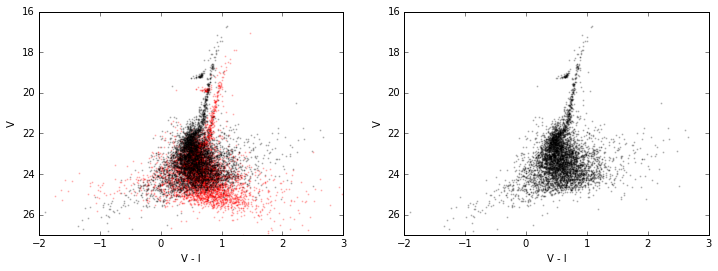

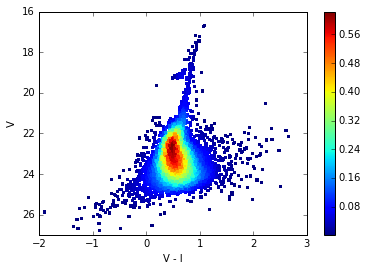

In [2]:
from scipy.stats import gaussian_kde
import tarea1_parte1
import numpy as np
import matplotlib.pyplot as plt

# Configuración para pyplot.
%matplotlib inline
#plt.rcParams['figure.figsize'] = (5.0, 5.0)

# Datos de la parte 1, magnitudes en F555 y F814.
Tarea1 = tarea1_parte1.Tarea1Parte1()
mag = zip(Tarea1.f555_mag, Tarea1.f814_mag)
params = (Tarea1.f555_zp, Tarea1.f814_zp, Tarea1.f555_av, Tarea1.f555_av)

# Magnitudes en V e I.
mag = list(map(lambda x: trans_to_UVBRI(x[0], x[1], *params), mag))

# Valores a graficar para V e I.
axis_x = list(map(lambda x: x[0]-x[1], mag))
_, axis_y = zip(*mag)

# Valores a graficar para f555 e f814.
f_axis_x = np.array(Tarea1.f555_mag) - np.array(Tarea1.f814_mag)
f_axis_y = Tarea1.f555_mag

# Graficar!
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Primero ambos gráficos
ax1.scatter(f_axis_x, f_axis_y, marker='o', color='Red', s=1, alpha=0.2)
ax1.scatter(axis_x, axis_y, marker='o', c='Black', s=1, alpha=0.2)

# Luego solo el segundo
ax2.scatter(axis_x, axis_y, marker='o', c='Black', s=1, alpha=0.2)

for ax in [ax1, ax2]:
    ax.set_xlabel('V - I')
    ax.set_ylabel('V')
    ax.set_xlim([-2, 3])
    ax.set_ylim([27, 16])
    #ax.invert_yaxis()
    
#plt.tight_layout()
plt.show()

# Ahora creamos el diagrama de Hess.
x = axis_x
y = axis_y

# Código adaptado del amigo de stackoverflow: 
# http://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
im = ax.scatter(x, y, c=z, s=10, marker='s', edgecolor='')
plt.xlabel('V - I')
plt.ylabel('V')
axes = plt.gca()
#axes.invert_yaxis()
axes.set_xlim([-2, 3])
axes.set_ylim([27, 16])
fig.colorbar(im)
plt.show()

Buscamos una isócrona para NGC 121. Para ello utilizaremos los siguientes datos conocidos:
1. [Edad](http://iopscience.iop.org/article/10.1088/0004-6256/135/4/1106/pdf) de 10.5 Gyr. 
2. [Distancia](http://ned.ipac.caltech.edu/cgi-bin/objsearch?search_type=Obj_id&objid=3284737&objname=1&img_stamp=YES&hconst=73.0&omegam=0.27&omegav=0.73&corr_z=1) de 0.061 Mpc.
3. [Metalicidad](https://arxiv.org/pdf/1002.4301v2.pdf) de -1.5 dex.

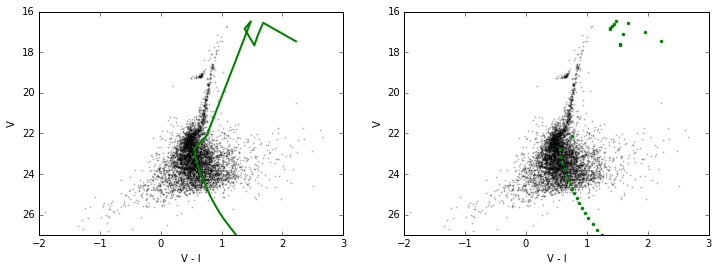

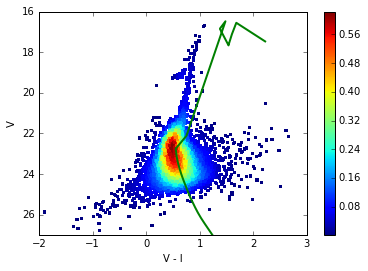

In [3]:
from isochrones.dartmouth import Dartmouth_Isochrone
import numpy as np

# Parámetros
age = np.log10(10.5*(10**9)) 
distance = 61000
fe_h = -1.5
a_v = [0.101, 0.056]

# Creamos la isócrona y extraemos V e I.
isochrone = Dartmouth_Isochrone(['V','I'])
model = isochrone.isochrone(age, fe_h, distance=distance, AV=a_v[0])
model_y = model.V_mag
model_x = model.V_mag - model.I_mag

# Graficamos!
# Graficar!
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Primero ambos gráficos
ax1.plot(model_x, model_y, '-g', linewidth=2.0)
ax1.scatter(x, y, marker='o', c='Black', s=1, alpha=0.2)

# Luego solo el segundo
ax2.plot(model_x, model_y, 'g.', linewidth=2.0)
ax2.scatter(x, y, marker='o', c='Black', s=1, alpha=0.2)

for ax in [ax1, ax2]:
    ax.set_xlabel('V - I')
    ax.set_ylabel('V')
    ax.set_xlim([-2, 3])
    ax.set_ylim([27, 16])
    #ax.invert_yaxis()
    
#plt.tight_layout()
plt.show()

# Comparamos con un diagrama de Hess.
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
im = ax.scatter(x, y, c=z, s=10, marker='s', edgecolor='')
axes = plt.gca()
fig.colorbar(im)
#axes.invert_yaxis()
plt.plot(model_x, model_y, '-g', linewidth=2.0)
axes.set_xlim([-2, 3])
axes.set_ylim([27, 16])
plt.xlabel('V - I')
plt.ylabel('V')
plt.show()


La isócrona no coincide con nuestro CMD. Esto se debe a que al momento de obtener la magnitud de cada estrella se utilizó una ganancia incorrecta, además la forma en que se expresó el reddening no fue la correcta.
Para corregir esto, utilizaremos 

Necesitamos conocer la "ridge line" del CMD. Como las estrellas post-secuencia principal son menos, utilizaremos dos bins.

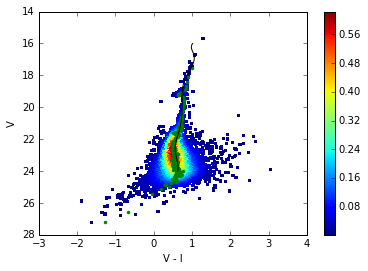

In [4]:
from scipy.interpolate import splrep, splev

bin_ms = 40
bin_pms = 8

x_fits = []
y_fits = []

# Ordenamos las estrellas para poder dividir en bins.
xy = list(zip(y, x))
xy.sort()
y, x = zip(*xy)
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
temp_x = list(x)
temp_y = list(y)


for bin_id in [bin_pms, bin_ms]:
    for num in range(0, len(temp_x), bin_id):
        if temp_y[num] < 21.8 or bin_id == bin_ms:
            x_fits.append(np.median(temp_x[num: num+bin_id]))
            y_max = np.max(temp_y[num: num+bin_id])
            y_min = np.max(temp_y[num: num+bin_id])
            y_fits.append((y_max+y_min)/2)
        else:
            del temp_x[0: del_ind]
            del temp_y[0: del_ind]
            break
        del_ind = num

# spline de los datos originales
nknots = 7
knots = np.arange(y[1], y[len(y)-1],(y[len(y)-1]-y[1])/np.double(nknots))
tck = splrep(y, x, t=knots)
y_range = np.linspace(16, 24, 182)
fit = splev(y_range, tck)

fig, ax = plt.subplots()
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
im = ax.scatter(x, y, c=z, s=10, marker='s', edgecolor='')
axes = plt.gca()
fig.colorbar(im)
axes.invert_yaxis()

plt.plot(x_fits, y_fits, 'g.')
plt.plot(fit, y_range, '-', color='black')
plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.xlabel('V - I')
plt.ylabel('V')
plt.show()

Buscamos el mejor fit para los parámetros del cúmulo:

6.18495896133
6.18496313281
6.18495894052
6.18495896133
4.3902436353
4.39024526201
4.39024360416
4.3902436353
3.67609836668
3.67609976047
3.67609833995
3.67609836668
3.50499981357
3.50500038358
3.50499978869
3.50499981357
3.47915754766
3.47915982026
3.47915753641
3.47915754766
3.33399036453
3.33399135643
3.33399034794
3.33399036453
3.29132987885
3.29133041843
3.29132985443
3.29132987885
2.87565850643
2.87565942031
2.8756584981
2.87565850643
2.81548464207
2.81548510328
2.81548462947
2.81548464207
2.79551150532
2.79551189249
2.79551149315
2.79551150532
2.79059007983
2.7905913539
2.79059007653
2.79059007983
2.69829498575
2.6982960019
2.69829498466
2.69829498575
2.66620793885
2.66620905442
2.66620794093
2.66620793885
2.66202494485
2.66202566492
2.66202494476
2.66202494485
2.65068701566
2.65068836799
2.65068702405
2.65068701566
2.67147250078
2.64166318754
2.64166445699
2.64166319532
2.64166318754
2.69747910319
2.64264582964
`xtol` termination condition is satisfied.
Function evaluations: 19

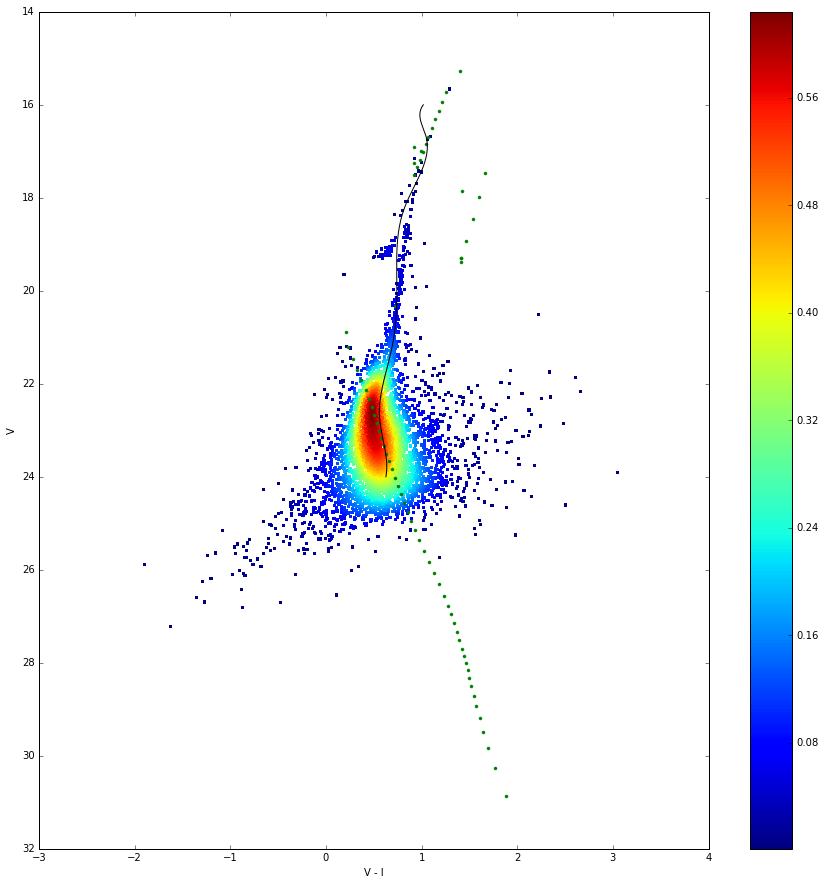

In [5]:
from scipy.optimize import least_squares
import pandas as pd

# Corresponde a la isócrona
def fun_isochrone(params, tck_fit):
    length = 50
    # Crea la isócrona
    isochrone = Dartmouth_Isochrone(['V','I'])
    model = isochrone.isochrone(params[0], params[1], distance=params[2], AV=a_v[0])
    
    # Obtiene lso ejes x e y.
    model_x = model.V_mag - model.I_mag
    model_y = model.V_mag
    tuples = list(zip(model_y, model_x))
    tuples.sort()
    tuples = list(filter(lambda x: not pd.isnull(x[0]), tuples))

    if len(tuples) < 50:
        return 5*np.random.random_sample(50) + 50*np.ones(50)
    else:
        tuples = tuples[0: 50]

    y_range = np.linspace(16, 24, 50)
    fit = splev(y_range, tck)
    fit = list(zip(y_range, fit))
    fit.sort()
    
    # Obtiene el valor.
    _, x_returned = zip(*tuples)
    _, fit = zip(*fit)  
    
    return np.array(fit)-np.array(x_returned)
    

# Queremos ajustar our_iso.isochrone() a fit.
def err(params, tck_fit):
    error = fun_isochrone(params, tck_fit)
    norm = np.linalg.norm(error)
    print(norm)
    return error


x0 = [np.log10(1*(10**10)), -1, 60000]
inf_x = [np.log10(1*(10**9)), -2, 40000]
sup_x = [np.log10(1*(10**11)), 0, 80000]

x_fits = fit
y_fits = y_range

res_lsq = least_squares(err, x0, args=(tck,), 
                        bounds=(inf_x, sup_x), max_nfev=50, 
                        #ftol= 2.220446049250313e-16,
                        #xtol= 2.220446049250313e-16,
                        #gtol= 2.220446049250313e-16,
                        #diff_step = [np.log10(1*(10**9)), 0.1, 10000], 
                        verbose=1)
print("Years: {:.2e} yr\nMetallicity: {} dex\nDistance: {} pc".format(10**res_lsq.x[0], res_lsq.x[1], res_lsq.x[2]))

isochrone = Dartmouth_Isochrone(['V','I'])
model = isochrone.isochrone(res_lsq.x[0], res_lsq.x[1], distance=res_lsq.x[2], AV=a_v[0])
x_fits = model.V_mag - model.I_mag
y_fits = model.V_mag
fig, ax = plt.subplots()
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
im = ax.scatter(x, y, c=z, s=10, marker='s', edgecolor='')
axes = plt.gca()
fig.colorbar(im)
axes.invert_yaxis()

plt.plot(x_fits, y_fits, 'g.')
plt.plot(fit, y_range, '-', color='black')
plt.xlabel('V - I')
plt.ylabel('V')
plt.show()
